In [25]:
import theano
import lasagne
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from nolearn.lasagne import NeuralNet
from lasagne.updates import nesterov_momentum
from nolearn.lasagne import BatchIterator
from lasagne.layers import InputLayer, Conv2DLayer, DropoutLayer,\
    MaxPool2DLayer, DenseLayer
from lasagne.nonlinearities import softmax

In [26]:
df = pd.read_csv('data/imdb.csv')

In [27]:
a = df.corr()
a

,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_1_facebook_likes,gross,num_voted_users,cast_total_facebook_likes,facenumber_in_poster,num_user_for_reviews,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
num_critic_for_reviews,1.000000,0.258486,0.180674,0.271646,0.190016,0.480601,0.624943,0.263203,-0.033897,0.609387,0.119994,0.275707,0.282306,0.305303,-0.049786,0.683176
duration,0.258486,1.000000,0.173296,0.123558,0.088449,0.250298,0.314765,0.123074,0.013469,0.328403,0.074276,-0.135038,0.131673,0.261662,-0.090071,0.196605
director_facebook_likes,0.180674,0.173296,1.000000,0.120199,0.090723,0.144945,0.297057,0.119549,-0.041268,0.221890,0.021090,-0.063820,0.119601,0.170802,0.001642,0.162048
actor_3_facebook_likes,0.271646,0.123558,0.120199,1.000000,0.249927,0.308026,0.287239,0.473920,0.099368,0.230189,0.047451,0.096137,0.559662,0.052633,-0.003366,0.278844
actor_1_facebook_likes,0.190016,0.088449,0.090723,0.249927,1.000000,0.154468,0.192804,0.951661,0.072257,0.145461,0.022639,0.086873,0.390487,0.076099,-0.020049,0.135348
gross,0.480601,0.250298,0.144945,0.308026,0.154468,1.000000,0.637271,0.247400,-0.027755,0.559958,0.102179,0.030886,0.262768,0.198021,0.069346,0.378082
num_voted_users,0.624943,0.314765,0.297057,0.287239,0.192804,0.637271,1.000000,0.265911,-0.026998,0.798406,0.079621,0.007397,0.270790,0.410965,-0.014761,0.537924
cast_total_facebook_likes,0.263203,0.123074,0.119549,0.473920,0.951661,0.247400,0.265911,1.000000,0.091475,0.206923,0.036557,0.109971,0.628404,0.085787,-0.017885,0.209786
facenumber_in_poster,-0.033897,0.013469,-0.041268,0.099368,0.072257,-0.027755,-0.026998,0.091475,1.000000,-0.069018,-0.019559,0.061504,0.071228,-0.062958,0.013713,0.008918
num_user_for_reviews,0.609387,0.328403,0.221890,0.230189,0.145461,0.559958,0.798406,0.206923,-0.069018,1.000000,0.084292,-0.003147,0.219496,0.292475,-0.024719,0.400594


/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


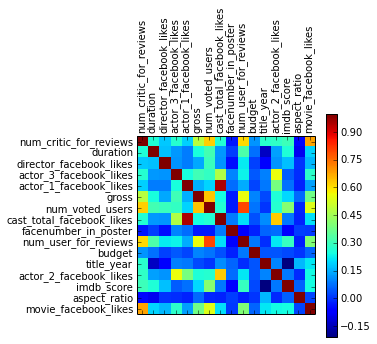

In [28]:
% matplotlib inline
import matplotlib.pyplot as plt

df_corr = df[a.columns.tolist()]

plt.matshow(df_corr.corr())
plt.xticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist(), rotation="vertical")
plt.yticks(np.arange(0, len(df_corr.columns)), df_corr.columns.tolist())
plt.colorbar()
plt.show()

In [29]:
df.drop('movie_imdb_link', axis=1, inplace=True)
df.drop('content_rating', axis=1, inplace=True)
df.drop('budget', axis=1, inplace=True)
df.drop('color', axis=1, inplace=True)
df.drop('movie_title', axis=1, inplace=True)
#df.drop('plot_keywords', axis=1, inplace=True)

In [30]:
## Para obtener los indices de los paises y los lenguajes de las peliculas
idx_language, label_language = pd.factorize(df['language'])
idx_country, label_country = pd.factorize(df['country'])

## Para obtener los indices de los actores
idx_actor1, label_actor1 = pd.factorize(df['actor_1_name'])
idx_actor2, label_actor2 = pd.factorize(df['actor_2_name'])
idx_actor3, label_actor3 = pd.factorize(df['actor_3_name'])

## Para obtener el indice del director
idx_director, label_director = pd.factorize(df['director_name'])

In [31]:
df = pd.concat([df, df.genres.str.get_dummies(sep='|')], axis=1)
df.drop('genres', axis=1, inplace=True)

In [32]:
#Se debe realizar etiquetado de los nombres de los actores y directores

In [33]:
# df = pd.concat([df, df.plot_keywords.str.get_dummies(sep='|')], axis=1)
# a = df.plot_keywords.str.get_dummies(sep='|')
df.drop('plot_keywords', axis=1, inplace=True)

In [34]:
df['language'] = idx_language
df['country'] = idx_country
df['actor_1_name'] = idx_actor1
df['actor_2_name'] = idx_actor2
df['actor_3_name'] = idx_actor3
df['director_name'] = idx_director

In [35]:
df.fillna(value=-1, inplace=True)

In [36]:
from sklearn.decomposition import PCA, RandomizedPCA # using randomized Singular Value Decomposition 
#Xp = RandomizedPCA(n_components=2, random_state=1).fit_transform(xs)
#Xp

In [37]:
ys = df['imdb_score']
df.drop('imdb_score', axis=1, inplace=True)

In [43]:
df_test = df[['cast_total_facebook_likes',
              'actor_1_facebook_likes',
              'num_voted_users',
              'num_user_for_reviews',
              'num_critic_for_reviews',
              'movie_facebook_likes',
              'gross'
             ]]

In [44]:
xs = df_test.values

In [45]:
std_x = MinMaxScaler([-1,1])
xs = std_x.fit_transform(xs)
std_y = MinMaxScaler([-1,1])
ys = std_y.fit_transform(ys)
print (np.min(ys))
print (np.max(ys))
print (xs.shape)
print (ys.shape)
print (df.columns)
# print(xs)
#std.fit(xs)
#xs = std.transform(xs);

-1.0
1.0
(5043, 7)
(5043,)
Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'num_user_for_reviews', 'language', 'country', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')


/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:324: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/leandro/virtualenvs/DSS/lib/python3.4/site-packages/sklearn/preprocessing/data.py:359: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [46]:
#Xp = PCA(n_components=2)
#Xp.fit_transform(xs)

from sklearn.decomposition import RandomizedPCA # using randomized Singular Value Decomposition 
Xp = RandomizedPCA(n_components=2, random_state=1)
Xp = Xp.fit_transform(xs)

In [47]:
y = np.array(ys)

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


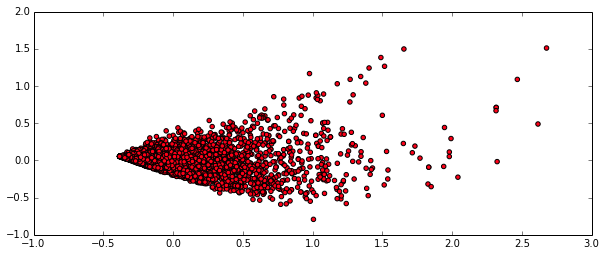

In [48]:
% matplotlib inline
import matplotlib.pyplot as plt

# get the product class 
product_class = np.unique(y)

colors = plt.get_cmap("hsv")

plt.figure(figsize=(10, 4))
for i, p in enumerate(product_class):
    mask = (y == p)
    plt.scatter(Xp[mask, 0], Xp[mask, 1], 
                c=colors(1. * i / 11), label=p)
    
#plt.legend(loc="best")

/usr/lib/python3/dist-packages/matplotlib/collections.py:549: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


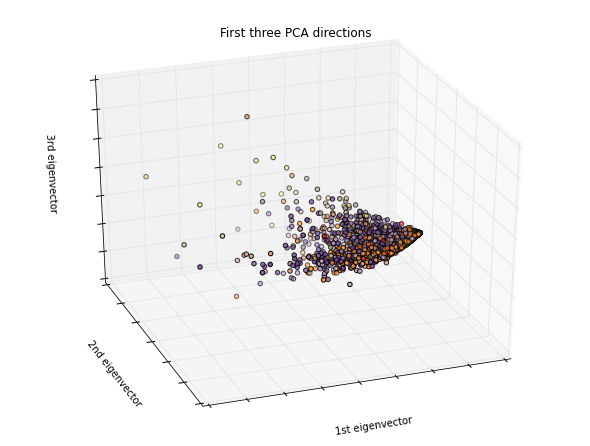

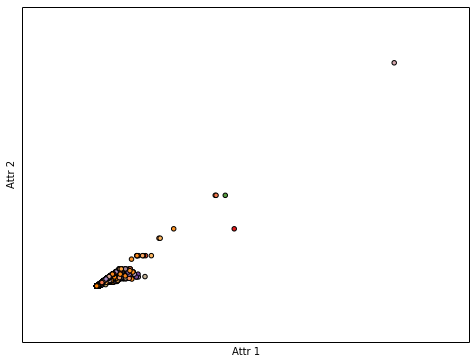

In [49]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

# import some data to play with
#iris = datasets.load_iris()
#X = iris.data[:, :2]  # we only take the first two features.
#Y = iris.target

X = xs
Y = ys

x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

plt.figure(2, figsize=(8, 6))
plt.clf()

# Plot the training points
plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
plt.xlabel('Attr 1')
plt.ylabel('Attr 2')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())

# To getter a better understanding of interaction of the dimensions
# plot the first three PCA dimensions
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = PCA(n_components=3).fit_transform(xs)
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=Y,
           cmap=plt.cm.Paired)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [ ]:
#from sklearn.ensemble import ExtraTreesClassifier
#clf = ExtraTreesClassifier(n_estimators=200,max_features=0.2,n_jobs=2,max_depth=None,min_samples_split=1,
#                           random_state=1)

In [50]:
from sklearn.tree import ExtraTreeRegressor
from sklearn.cross_validation import train_test_split
#X = preprocessing.scale(xs, axis=1)
#y = np.array(ys).ravel()

#xs = xs.astype(np.float32)
#ys = xs.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(xs, ys,random_state=1)

clf = ExtraTreeRegressor(max_features=0.2,max_depth=None,min_samples_split=1,
                           random_state=1)

In [51]:
clf.fit(X_train, y_train)


ExtraTreeRegressor(criterion='mse', max_depth=None, max_features=0.2,
          max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=1,
          min_weight_fraction_leaf=0.0, random_state=1, splitter='random')

In [52]:
#print classification_report(clf.predict(X_test), y_test)
#print clf.score(X_test, y_test)
#plot_matrix(clf, X_test, y_test)

In [53]:
importances = clf.feature_importances_
print (importances)

[ 0.12677172  0.12223366  0.2552741   0.10536095  0.13383273  0.11150775
  0.1450191 ]


In [54]:
df.columns

Index(['director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'num_user_for_reviews', 'language', 'country', 'title_year',
       'actor_2_facebook_likes', 'aspect_ratio', 'movie_facebook_likes',
       'Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Game-Show',
       'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News',
       'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Thriller', 'War',
       'Western'],
      dtype='object')

AssertionError: incompatible sizes: argument 'height' must be length 46 or scalar

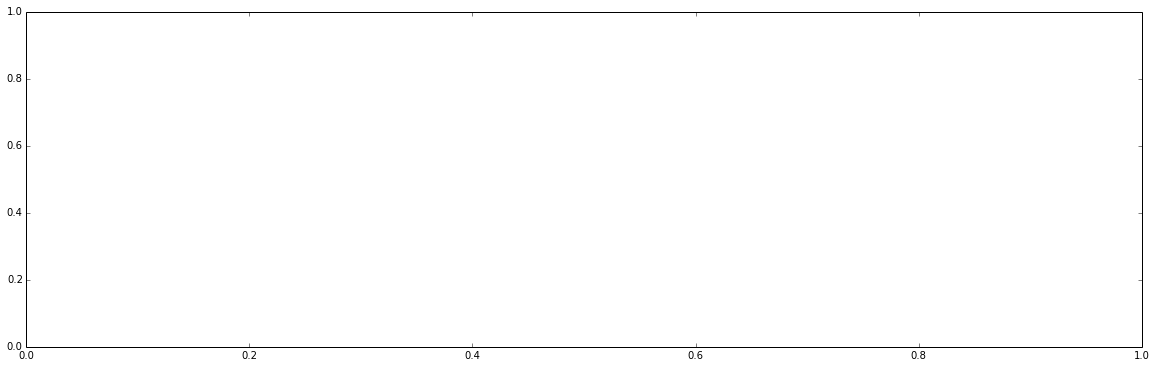

In [55]:
import matplotlib.pyplot as plt
#text = map(lambda i: df.columns[1:-1][i], range(93))
text = list(map(lambda i: df.columns[i], range(len(df.columns))))
plt.figure(figsize=(20, 6))
plt.bar(range(len(df.columns)),height=importances,  width=1.)
plt.xticks(np.arange(0.5, len(df.columns), 1.), text, rotation=90)
plt.xlim((0, len(df.columns)))
plt.show()
# Top 10
#indices = np.argsort(importances)[::-1]
#for i in range(10):
    #print importances[indices[i]], df.columns[1:-1][indices[i]]

In [56]:
y_test

array([ 0.34177215,  0.06329114,  0.3164557 , ...,  0.64556962,
        0.24050633,  0.16455696])

In [57]:
from sklearn.metrics import r2_score
r2_score(y_test,clf.predict(X_test))

-0.48131688124817829

In [ ]:

from sklearn.grid_search import GridSearchCV
parameter_grid = {
    #'n_estimators': [100, 200],
    #'max_features': [0.2, 0.5],
    'max_depth': [5., None]
}
grid_search = GridSearchCV(clf, parameter_grid,
                            cv=5, verbose=3)

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.grid_scores_

In [ ]:
grid_search.best_params_

# Red Neuronal

In [59]:
layers_0 = [
                (InputLayer, {'shape': (None, 7)}),
                (DenseLayer, {'num_units': 512}),
                #(DropoutLayer, {}),
                (DenseLayer, {'num_units': 512}),
                (DenseLayer, {'num_units': 1, 'nonlinearity': None}),
        ]

In [60]:
class AdjustVariable(object):
    """
    Used to decreases linearly the learning rate with the number of epochs,
    while we the momentum increase.
    """
    def __init__(self, name, start=0.03, stop=0.001):
        self.name = name
        self.start, self.stop = start, stop
        self.ls = None

    def __call__(self, nn, train_history):
        if self.ls is None:
            self.ls = np.linspace(self.start, self.stop, nn.max_epochs)

        epoch = train_history[-1]['epoch']
        new_value = np.float32(self.ls[epoch - 1])
        getattr(nn, self.name).set_value(new_value)

In [77]:
def create_network(npochs=100, batch_s=10000):
    return NeuralNet(
        layers=layers_0,
        update=nesterov_momentum,
        update_learning_rate=theano.shared(np.float32(0.000005)),
        update_momentum=theano.shared(np.float32(0.9)),

        regression=True,
        #batch_iterator_train=BatchIterator(batch_size=batch_s),
        on_epoch_finished=[
            AdjustVariable('update_learning_rate', start=0.00005, stop=0.000005),
            AdjustVariable('update_momentum', start=0.9, stop=0.9999)
        ],
        max_epochs=npochs,
        verbose=1)
net0 = create_network(npochs=1500)

In [ ]:
y_train = y_train.astype(np.float32)
X_train = X_train.astype(np.float32)

net0.fit(X_train, y_train)

# Neural Network with 267265 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input0       7
  1  dense1     512
  2  dense2     512
  3  dense3       1

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.18097     0.18266    0.99078  0.23s
      2     0.16507     0.14851    1.11158  0.24s
      3     0.13299     0.11982    1.10997  0.24s
      4     0.11262     0.10382    1.08480  0.26s
      5     0.10178     0.09504    1.07094  0.23s
      6     0.09601     0.09010    1.06559  0.25s
      7     0.09289     0.08724    1.06482  0.26s
      8     0.09115     0.08550    1.06603  0.24s
      9     0.09014     0.08440    1.06790  0.25s
     10     0.08950     0.08367    1.06975  0.38s
     11     0.08908     0.08315    1.07137  0.34s
     12     0.08877     0.08275    1.07271  0.36s
     13     0.08852     0.08244    1.07377  0.32s
     14     0.08831     0.08218    1.07458  0.23s
     15 

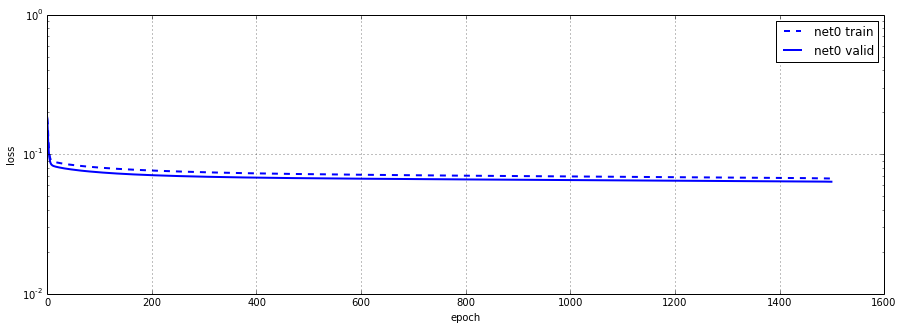

In [79]:
%matplotlib inline

plt.clf()
plt.figure(figsize=(15,5))

train_loss = np.array([i["train_loss"] for i in net0.train_history_])
valid_loss = np.array([i["valid_loss"] for i in net0.train_history_])
plt.plot(train_loss, '--b', linewidth=2, label="{} train".format("net0"))
plt.plot(valid_loss, '-b', linewidth=2, label="{} valid".format("net0"))

plt.grid()
plt.legend()
plt.xlabel("epoch")
plt.ylabel("loss")
plt.yscale("log")
plt.show()

In [80]:
from sklearn.metrics import r2_score

y = y_test.astype(np.float32) 

x = X_test.astype(np.float32)

r2_score(y,net0.predict(x))

0.20340053375239442